# Телеком — Определение неэффективных операторов

В нашем распоряжении данные о работе операторов колл центров. Необходимо определить критирии неэффективной работы операторов колл центров. На основании обобщенной оценки по критериям, был получен список неэффективных операторов. Так же выполнена категоризация колл центров по количеству входящих, исходящих звонков. 

**Цель исследования:** Выполнить оценку эффективности операторов, работающих в колл-центре.

**План**
1) Предобработка данных

2) Исследовательский анализ данных, определение критериев низкой эффективности оператора:
- среднее количество пропущенных входящих вызовов;
- среднее время ожидания клиента на обслуживания;
- среднее длительность звонка без учета учета времени на ожидания;
- обобщающие оценок по критериям.

3) Специализация колл-центров:
- определить общее количество звонков у операторов колл-центра
- выполнить разбивку по специализации колл-центров.



Название колонок, в переданном для анализе архиве:

- `user_id` — Идентификатор клиентского аккаунта колл-центра в сервисе
- `date` — Дата статистики
- `direction` — Направление вызовов (out - исходящий вызов, in — входящий вызов)
- `internal` — Является ли звонок внутренним звонком между операторами клиента
- `operator_id` — Идентификатор оператора
- `is_missed_call` — Является ли звонок пропущенным
- `calls_count` — Количество звонков
- `call_duration` — Длительность звонка (без учета времени ожидания)
- `total_call_duration` — Длительность звонка (с учетом времени ожидания)

In [1]:
#Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import datetime
import numpy as np
import seaborn as sns
import os
from scipy import stats as st

## Предобработка данных

In [2]:
#прочитаем данные, хохраним в df
pth3 = 'C:\\YandexWork\\final_project\\telecom_dataset.csv'
pth4 = '/datasets/telecom_dataset.csv'
if os.path.exists(pth3): 
    df = pd.read_csv(pth3) 
elif os.path.exists(pth4): 
    df = pd.read_csv(pth4) 
else: 
    print('Something is wrong')

df.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [3]:
# Получим общую информацию о дата фрейме, для определния типов данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [4]:
# Определим количество и пропусков в каждом из столбцов
df.isna().sum()

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [5]:
#Удалим все пропуски в столбце 'internal', их немного их удаление не повляиет на весь датасет
df=df.dropna(subset=['internal']).reset_index(drop=True)
# заменим пропуски в столбце operator_id на заглушки 'unknown'
df['operator_id']=df['operator_id'].fillna('unknown')
#Заменим типы данных в столбце date 
#df['date']=pd.to_datetime(df['date'],  format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m-%d')
df['date']=pd.to_datetime(df['date'],  format='%Y-%m-%d %H:%M:%S')
df = df. iloc [: , :9]
df.head(10)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,unknown,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25
5,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,False,2,3,29
6,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
7,166377,2019-08-05 00:00:00+03:00,in,False,unknown,True,6,0,35
8,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
9,166377,2019-08-06 00:00:00+03:00,in,False,unknown,True,4,0,62


In [6]:
# посчитаем явные дубликаты 
print('Количество явных дубликатов :', df.duplicated().sum())
# Явных дубликатов меньше 10% удалим их из датафрейма
df=df.drop_duplicates()
print('Количество явных дубликатов после удаления:', df.duplicated().sum())

Количество явных дубликатов : 4893
Количество явных дубликатов после удаления: 0


In [7]:
# добавим столбец:
#среднее время ожидания до ответа оператора
df['avg_time_duration']=(df['total_call_duration']-df ['call_duration'])/ df['calls_count']
#среднее количество звонков в день у оператора
df['avg_call_duration']=df['call_duration'] / df['calls_count']
#среднее длительность звонка (с учетом времени ожидания) 
df['avg_total_call_duration']=df['total_call_duration'] / df['calls_count']

In [8]:
# Выполним фильртрацию удалим все строки, в которых количество секунд больше 28800 (8 часовой рабочий день)
# значение количества звонков не превышает 400
norm_call_duration=28800
norm_calls_count=400

df=df.query('call_duration <= @norm_call_duration')
df=df.query('calls_count <= @norm_calls_count')

In [9]:
#Сгруппируем данные по дате, user_id, operator_id, просуммируем total_call_duration, что бы просмотреть максимальные значения 
df_group_operator=df.query('operator_id !="unknown"')\
                    .groupby(by=['date','user_id','operator_id'])\
                    .agg({'total_call_duration':'sum'})
print(df_group_operator.sort_values(by='total_call_duration', ascending=False).head())
# Переменная с аномальными операторами
operator_id_anomaly=[885876.0, 885890.0, 925922.0, "unknown"]
df_no_anomaly=df.loc[~df['operator_id'].isin(operator_id_anomaly)]
    
   
df_group_operator=df_no_anomaly.groupby(by=['date','user_id','operator_id']).agg({'total_call_duration':'sum'})

df_group_operator.sort_values(by='total_call_duration', ascending=False)

                                               total_call_duration
date                      user_id operator_id                     
2019-11-04 00:00:00+03:00 168361  945278.0                   61611
2019-09-09 00:00:00+03:00 166582  885890.0                   40959
2019-10-12 00:00:00+03:00 166582  925922.0                   39673
2019-10-02 00:00:00+03:00 166582  925922.0                   36959
2019-09-07 00:00:00+03:00 166582  885876.0                   36455


,,,total_call_duration
date,user_id,operator_id,
2019-11-04 00:00:00+03:00,168361,945278.0,61611
2019-11-26 00:00:00+03:00,168253,952948.0,36194
2019-10-25 00:00:00+03:00,167827,929428.0,35320
2019-10-28 00:00:00+03:00,167827,929428.0,30288
2019-11-22 00:00:00+03:00,168361,945310.0,29160
...,...,...,...
2019-09-26 00:00:00+03:00,167359,921316.0,0
2019-10-17 00:00:00+03:00,167756,938896.0,0
2019-11-27 00:00:00+03:00,167852,930690.0,0


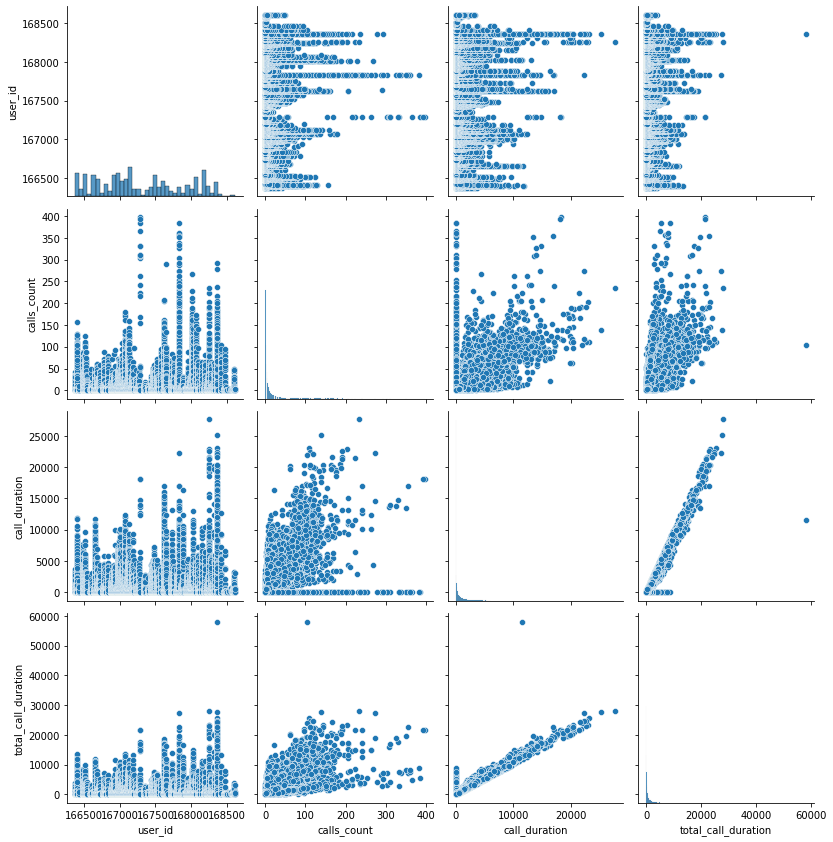

In [10]:
# Общее зависимости для оценки присутствуют ли анамальные значения после предобработки.
sns.pairplot(df_no_anomaly[['user_id', 'calls_count', 'call_duration', 'total_call_duration']])
plt.gcf().set_size_inches(12,12);

**Выполнена преобработка данных:**
- Из датафрейма были удалены 4893 явных дубликата;
- вывлены аномальные operator_id 885876.0, 885890.0, 925922.0 они все относятся к user_id = 166582 их время работы превышает фактически возможное значение в сутках, вероятно их занесли в базу неоднократно. Удалил данных операторов из анализа;
- выполнен изменение типа данных в столбце date;
- так как цель исследования задача выявить неэффективных операторов, мной удалены все строки, в которых отсутствовали данные о id_operatora;
- датафрейм  удалены строки, в которых количество секунд превышает 28800 (8 часовой рабочий день) и количества звонков превышает 400.


## Исследовательский анализ данных 

### Критерий 1 для операторов, работающих на входящих  - Процент пропущенных вызовов

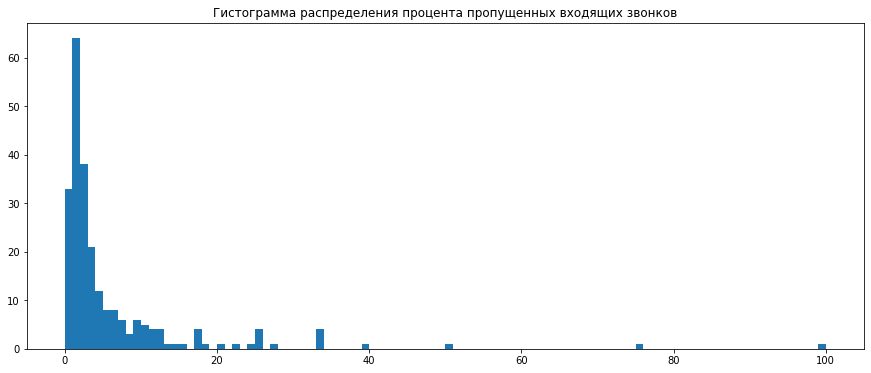

In [11]:

# Количесвто входящих звонков по кажлому из операторов
call_count=df_no_anomaly.query('direction == "in"').groupby(by='operator_id').agg({'calls_count':'sum'}).reset_index()
# Количество пропущенных входящих звонков по кажлому из операторов
call_missed=df_no_anomaly.query('is_missed_call != False & direction == "in"')\
                         .groupby(by='operator_id').agg({'calls_count':'sum'}).reset_index()


#Переименнование названия столбцов
call_missed.columns=['operator_id','call_missed']
#объединение таблиц с количество входящих звонков и пропущенных 
call_count=call_count.merge(call_missed, on='operator_id')
call_count['call_missed_percent']=round((call_count['call_missed']/call_count['calls_count'])*100,0)
call_count.head(20)
fig = plt.figure(figsize=(15, 6))
plt.hist(call_count['call_missed_percent'], bins=100);
plt.title("Гистограмма распределения процента пропущенных входящих звонков");

plt.show()

In [12]:
# Создадим стоблбец call_missed_effective и заполням 1 у операторов, у которых процент пропущенных звонков больше 8.
call_count['call_missed_effective'] = np.where(call_count['call_missed_percent'] > 8, 1, 0)
print('Процент неэффективных оператовров по критерию пропущенных звонков :',\
      round(call_count['call_missed_effective'].sum()/ call_count['call_missed_effective'].count()*100,1))
call_count.head()      


Процент неэффективных оператовров по критерию пропущенных звонков : 18.2


,operator_id,calls_count,call_missed,call_missed_percent,call_missed_effective
0,882680.0,99,3,3.0,0
1,882684.0,613,4,1.0,0
2,882686.0,766,6,1.0,0
3,882690.0,171,2,1.0,0
4,884408.0,35,4,11.0,1


**Определен критерий по количеству пропущенных звонков. Границы критериев были определены из открытых источников, в которых описывается критерии эффектисвности операторов колл центров. Границу критерия неэффективности оператора по количеству пропущенных звонков - 8% от общего числа звонков. Такому критерию не соотвествуют 18,2 % операторов**

### Критерий 2 для операторов, работающих на входящих - Время ожидания клиента на обслуживания 

   operator_id  avg_time_duration
0     879896.0          13.396199
1     879898.0          14.206548
2     880020.0           7.714286
3     880022.0          14.000000
4     880026.0           5.935185


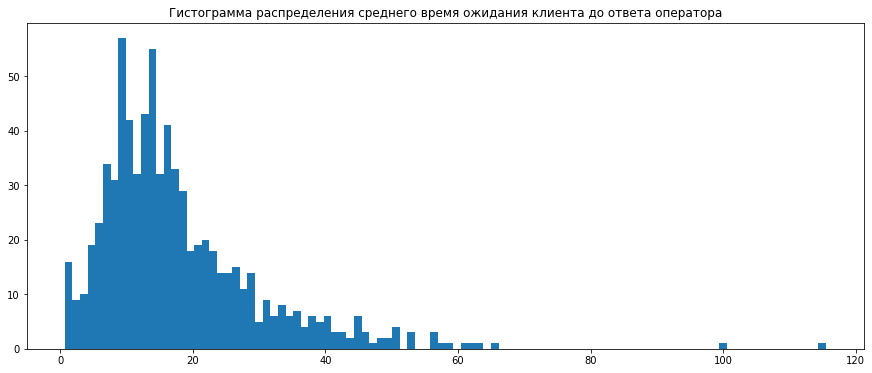

In [13]:
# Cреднее время ожидания до ответа оператора по всему временному интервалу
avg_time_expectation=df_no_anomaly.query('direction == "in"')\
                            .groupby(by='operator_id').agg({'avg_time_duration':'mean'}).reset_index()
print(avg_time_expectation.head())
fig = plt.figure(figsize=(15, 6))
plt.hist(avg_time_expectation['avg_time_duration'], bins=100);
plt.title("Гистограмма распределения среднего время ожидания клиента до ответа оператора");
plt.show()

In [14]:
# Создадим стоблбец avg_time_duration_effective и заполням 1 у операторов, у которых среднее время ожидания до ответа больше 25.
avg_time_expectation['avg_time_duration_effective'] = np.where(avg_time_expectation['avg_time_duration'] > 25, 1, 0)
print('Процент неэффективных операторов по критерию пропущенных звонков :',\
      round(avg_time_expectation['avg_time_duration_effective'].sum()\
            /avg_time_expectation['avg_time_duration_effective'].count()*100,1))
avg_time_expectation.head()     

Процент неэффективных операторов по критерию пропущенных звонков : 19.8


,operator_id,avg_time_duration,avg_time_duration_effective
0,879896.0,13.396199,0
1,879898.0,14.206548,0
2,880020.0,7.714286,0
3,880022.0,14.000000,0
4,880026.0,5.935185,0


**Определен критерий по времени ожидания клиентами ответа оператора.Критерием неэффетивного оператора время ожидания клиента на обслуживания более 25 секунд. 80% клиентов дожидаются ответа оператора в течении 25 секунд.**

### Критерий 3 для операторов, работающих на входящих - Средняя длительность звонка

   operator_id  avg_call_duration
0     879896.0         148.497703
1     879898.0          66.539881
2     880020.0          42.714286
3     880022.0          64.000000
4     880026.0          56.675926


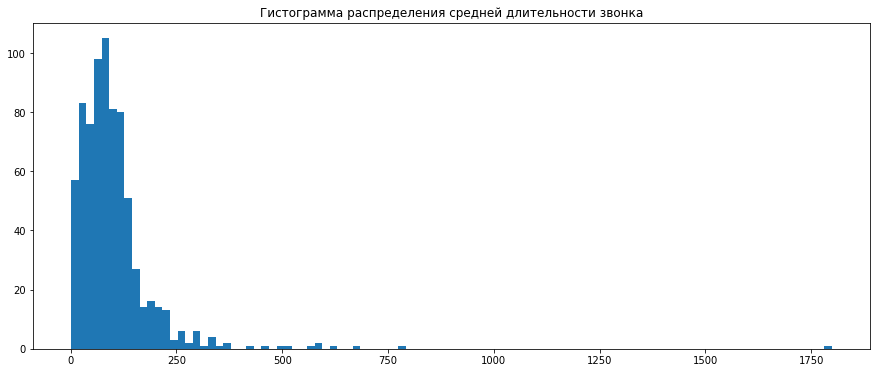

In [15]:
# Средней длительности звонка без учета времени на ожидания
avg_time_duration=df_no_anomaly.query('direction == "in"')\
                            .groupby(by='operator_id').agg({'avg_call_duration':'mean'}).reset_index()
print(avg_time_duration.head())
fig = plt.figure(figsize=(15, 6))
plt.hist(avg_time_duration['avg_call_duration'], bins=100);
plt.title("Гистограмма распределения средней длительности звонка");
plt.show()


In [16]:
# Создадим стоблбец avg_time_duration_effective и заполням 1 у операторов, у которых среднее время ожидания до ответа больше 240.
avg_time_duration['avg_call_duration_effective'] = np.where(avg_time_duration['avg_call_duration'] > 240, 1, 0)
print('Процент неэффективных операторов по критерию длительность звонка :',\
      round(avg_time_duration['avg_call_duration_effective'].sum()\
            /avg_time_duration['avg_call_duration_effective'].count()*100,1))
avg_time_duration.head()      


Процент неэффективных операторов по критерию длительность звонка : 4.8


,operator_id,avg_call_duration,avg_call_duration_effective
0,879896.0,148.497703,0
1,879898.0,66.539881,0
2,880020.0,42.714286,0
3,880022.0,64.000000,0
4,880026.0,56.675926,0


**Длительноть 95,2% звонков не превышает 240 секунд. Критерием неэффетивного оператора длительность звонка более 240 секунд (4 минуты).**

### Критерий 4 для операторов, работающих на исходящих звонках - среднее число звонков

   operator_id  calls_count
0     879896.0     9.083333
1     879898.0    42.405882
2     880020.0     2.923077
3     880022.0     3.048387
4     880026.0    13.463415


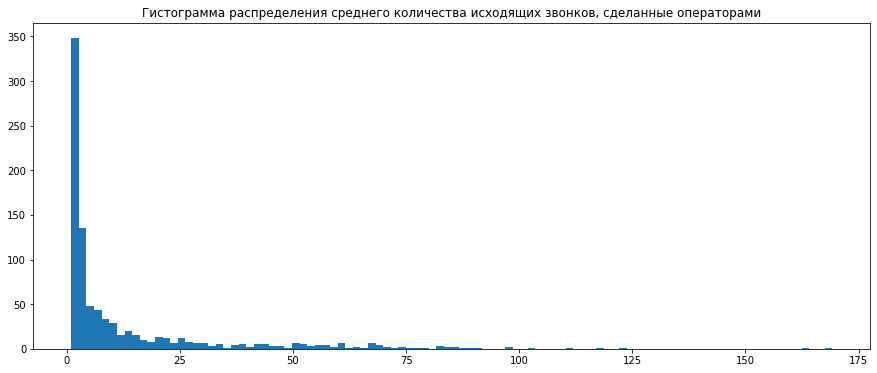

In [17]:
# Cреднее количество  исходящих звонков  
avg_count_outgoing_call=df_no_anomaly.query('direction == "out"')\
                            .groupby(by='operator_id').agg({'calls_count':'mean'}).reset_index()
print(avg_count_outgoing_call.head())
avg_count_outgoing_call.columns=['operator_id', 'avg_calls_count']

fig = plt.figure(figsize=(15, 6))
plt.hist(avg_count_outgoing_call['avg_calls_count'], bins=100);
plt.title("Гистограмма распределения среднего количества исходящих звонков, сделанные операторами");
plt.show()

In [18]:
# Создадим стоблбец avg_count_outgoing_call_effective и заполням 1 у операторов, у которых среднее количество звонков 20.
avg_count_outgoing_call['avg_count_outgoing_call_effective'] = np.where(avg_count_outgoing_call['avg_calls_count'] < 20, 1, 0)
print('Процент неэффективных операторов по критерию среднее количество звонков :',\
      round(avg_count_outgoing_call['avg_count_outgoing_call_effective'].sum()\
            /avg_count_outgoing_call['avg_count_outgoing_call_effective'].count()*100,1))
avg_count_outgoing_call.head()  

Процент неэффективных операторов по критерию среднее количество звонков : 81.1


,operator_id,avg_calls_count,avg_count_outgoing_call_effective
0,879896.0,9.083333,1
1,879898.0,42.405882,0
2,880020.0,2.923077,1
3,880022.0,3.048387,1
4,880026.0,13.463415,1


**Среднее количество звонков у 89,2% операторов не превышает 20 (критерий неэффетивного оператора количество звонка менее 20).**

### Критерий 5 для операторов, работающих на исходящих звонках -  время, которое уходит на один звонок

   operator_id  call_duration
0     879896.0     606.729167
1     879898.0    1476.694118
2     880020.0     149.692308
3     880022.0     236.048387
4     880026.0     925.237805


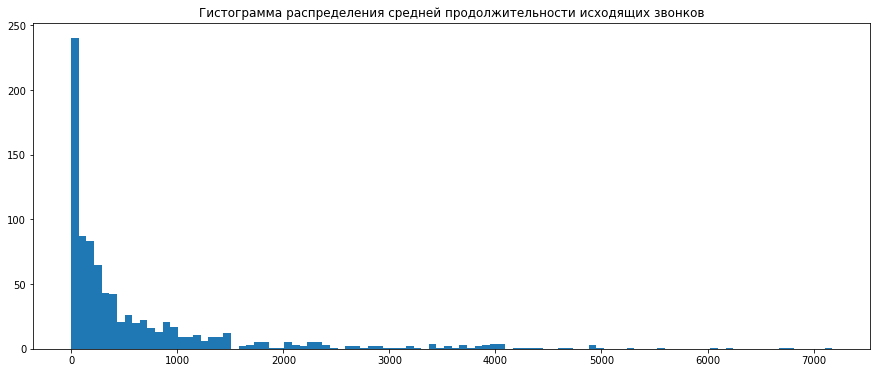

In [19]:
# Cреднее время одного звонка
avg_duration_outgoing_call=df_no_anomaly.query('direction == "out"')\
                            .groupby(by='operator_id').agg({'call_duration':'mean'}).reset_index()
print(avg_duration_outgoing_call.head())
avg_duration_outgoing_call.columns=['operator_id', 'avg_duration_outgoing']

fig = plt.figure(figsize=(15, 6))
plt.hist(avg_duration_outgoing_call['avg_duration_outgoing'], bins=100);
plt.title("Гистограмма распределения средней продолжительности исходящих звонков");
plt.show()

In [20]:
# Создадим стоблбец avg_duration_outgoing_call_effective и заполням 1 у операторов, у которых среднее количество звонков 240.
avg_duration_outgoing_call['avg_duration_outgoing_call_effective'] = np.where(avg_duration_outgoing_call['avg_duration_outgoing'] > 240, 1, 0)
print('Процент неэффективных операторов по критерию среднее количество звонков :',\
      round(avg_duration_outgoing_call['avg_duration_outgoing_call_effective'].sum()\
            /avg_duration_outgoing_call['avg_duration_outgoing_call_effective'].count()*100,1))
avg_count_outgoing_call.head()  

Процент неэффективных операторов по критерию среднее количество звонков : 50.6


,operator_id,avg_calls_count,avg_count_outgoing_call_effective
0,879896.0,9.083333,1
1,879898.0,42.405882,0
2,880020.0,2.923077,1
3,880022.0,3.048387,1
4,880026.0,13.463415,1


### Выявление неэффективных опареторов (агрегация по критериев)

In [21]:
# Объединим датафрейм без анмалий с оценками выставленными про пяти критериям неэффективности
# Критерий 1- Процент пропущенных вызовов 
df_no_anomaly=df_no_anomaly.merge(call_count[['operator_id','call_missed_effective']], on='operator_id')
# Критерий 2  - Время ожидания клиента на обслуживания¶
df_no_anomaly=df_no_anomaly.merge(avg_time_expectation[['operator_id', 'avg_time_duration_effective']], on='operator_id')
# Критерий 3  - Средняя длительность звонка
df_no_anomaly=df_no_anomaly.merge(avg_time_duration [['operator_id','avg_call_duration_effective']], on='operator_id')
# Критерий 4 для операторов, работающих на исходящих звонках - число звонков
df_no_anomaly=df_no_anomaly.merge(avg_count_outgoing_call [['operator_id','avg_count_outgoing_call_effective']], on='operator_id')
# Критерий 5 для операторов, работающих на исходящих звонках - время, которое уходит на один звонок
df_no_anomaly=df_no_anomaly.merge(avg_duration_outgoing_call [['operator_id','avg_duration_outgoing_call_effective']], on='operator_id')

In [22]:
# Суммируем оценки эффективности, запишем общую неэффективность в столбец 'total_not_effective'  
df_no_anomaly['total_not_effective']=df_no_anomaly['call_missed_effective']\
                                    +df_no_anomaly['avg_time_duration_effective']+df_no_anomaly['avg_call_duration_effective']\
                                    +df_no_anomaly['avg_count_outgoing_call_effective']+df_no_anomaly['avg_duration_outgoing_call_effective']
#Получим неэффетивных операторов в датафрейме 
operator_id_not_effective=df_no_anomaly.query('total_not_effective >= 2')
# выведем уникальных операторов датафрейма operator_id_not_effective

print('Список неэффектиных операторов :', operator_id_not_effective['operator_id'].unique())
print('Количество неэффектиных операторов :', operator_id_not_effective['operator_id'].nunique())

Список неэффектиных операторов : [882684.0 882686.0 902510.0 902532.0 882690.0 939478.0 888534.0 888532.0
 887276.0 959312.0 884408.0 906680.0 891410.0 891414.0 925826.0 908958.0
 893420.0 897872.0 890404.0 890406.0 888406.0 890618.0 900892.0 890228.0
 899082.0 889754.0 894232.0 894224.0 894230.0 893804.0 899250.0 895776.0
 906396.0 906392.0 906404.0 906400.0 906408.0 906410.0 906406.0 906412.0
 900352.0 900354.0 901884.0 901880.0 909134.0 903318.0 898414.0 923528.0
 923526.0 904044.0 913942.0 905542.0 905538.0 905566.0 926490.0 904344.0
 912296.0 906070.0 905862.0 913788.0 919554.0 919552.0 920902.0 920852.0
 920706.0 921814.0 921818.0 944646.0 915556.0 924948.0 924930.0 924928.0
 924954.0 919792.0 919794.0 917852.0 928382.0 964510.0 919218.0 926872.0
 937368.0 918888.0 920666.0 924546.0 921320.0 939708.0 918978.0 929424.0
 940430.0 940442.0 930020.0 928888.0 928886.0 929876.0 944220.0 944226.0
 944218.0 944222.0 944216.0 941844.0 937432.0 958460.0 958452.0 958434.0
 939370.0 939376.0

**После критерия при попадании в границы неэффективной работы, оператору присваивалась метка (1). Далее выполнена обощающая оценка неэффективности оператора, которая  включала сумму меток критериев, если оператор наберает  2-х и более балла - его считаем неэффективным.**

## Специализация колл-центров

In [23]:
# Рассчитаем количесвто звонков каждого из колл центров
user_id_calls_count=df_no_anomaly.groupby(by='user_id').agg({'calls_count':'sum'}).reset_index()
# Рассчитаем количесвто входящих звонков каждого из колл центров
user_id_calls_count_in=df_no_anomaly.query('direction == "in"').groupby(by='user_id').agg({'calls_count':'sum'}).reset_index()
#Заменим имена столбцов, что бы в дальнейшем  объединить датафреймы 
user_id_calls_count_in=user_id_calls_count_in.rename(columns={'calls_count':'calls_count_in'})
#Объедине датафреймов 
user_id_calls_count=user_id_calls_count.merge(user_id_calls_count_in, on='user_id')
# Доля входящих звонков по отношению к общему количеству звонков, обрабатывющих колл центром
user_id_calls_count['calls_count_in_percent']=round(user_id_calls_count['calls_count_in']\
                                                    / user_id_calls_count['calls_count']*100,0)
# Доля исходящих звонков по отношению к общему количеству звонков, обрабатывющих колл центром
user_id_calls_count['calls_count_out_percent']= 100-user_id_calls_count['calls_count_in_percent']
user_id_calls_count.head()


,user_id,calls_count,calls_count_in,calls_count_in_percent,calls_count_out_percent
0,166405,10462,1970,19.0,81.0
1,166407,576,73,13.0,87.0
2,166485,1327,431,32.0,68.0
3,166487,201,56,28.0,72.0
4,166503,415,230,55.0,45.0


In [24]:
# Создадим столбце с специализацией колл-центров.
user_id_calls_count.loc[user_id_calls_count['calls_count_in_percent'] <= 40, 'user_id_category'] = 'категория исходящие'

user_id_calls_count.loc[((user_id_calls_count['calls_count_in_percent'] > 40)\
                         & (user_id_calls_count['calls_count_in_percent'] <= 60)),\
                        'user_id_category'] = 'категория исходящие и входящие '

user_id_calls_count.loc[user_id_calls_count['calls_count_in_percent'] > 60, 'user_id_category'] = 'категория входящие'
user_id_calls_count.head(10)

,user_id,calls_count,calls_count_in,calls_count_in_percent,calls_count_out_percent,user_id_category
0,166405,10462,1970,19.0,81.0,категория исходящие
1,166407,576,73,13.0,87.0,категория исходящие
2,166485,1327,431,32.0,68.0,категория исходящие
3,166487,201,56,28.0,72.0,категория исходящие
4,166503,415,230,55.0,45.0,категория исходящие и входящие
5,166511,6398,1163,18.0,82.0,категория исходящие
6,166536,765,212,28.0,72.0,категория исходящие
7,166541,1864,1644,88.0,12.0,категория входящие
8,166604,623,543,87.0,13.0,категория входящие
9,166619,52,3,6.0,94.0,категория исходящие


,user_id_category
user_id_category,
категория входящие,23
категория исходящие,53
категория исходящие и входящие,20


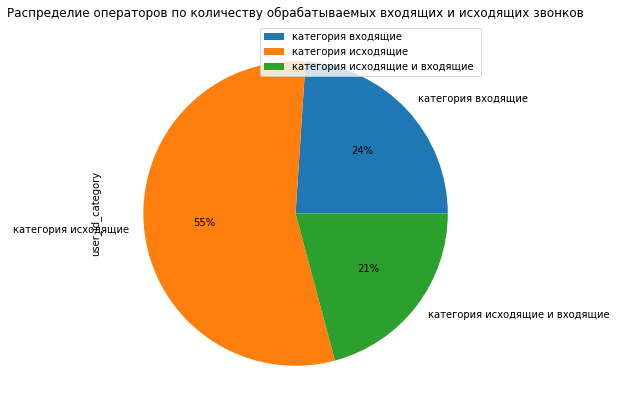

In [25]:
user_id_calls_count.groupby(by='user_id_category').agg({'user_id_category':'count'})\
                .plot(kind='pie', y='user_id_category', autopct='%1.0f%%',\
                      title='Распределие операторов по количеству обрабатываемых входящих и исходящих звонков',figsize=(7, 7));
user_id_calls_count.groupby(by='user_id_category').agg({'user_id_category':'count'})

**Выполнена категоризация колл центров по работы в зависимости от количества входящих и исходящих звонков.**

## Гипотезы для проверки 

### Среднее количество звонков в выходные равно среднему количеству звонков в будни. 

H_0: Среднее количество звонков (calls_count) в выходные равно среднему количеству звонков в будни`

H_a: Среднее количество звонков (calls_count) в выходные не равно среднее количество звонков в будни`
alpha = 0.05

In [26]:
df_no_anomaly['date']=pd.to_datetime(df['date'])
df_no_anomaly['day_week']=pd.to_datetime(df_no_anomaly['date']). dt.weekday

# Сгруппируем выборку количества звонков в будни 
weekdays_calls_count=df_no_anomaly.query('day_week !=5 & day_week !=6')['calls_count']
# Сгруппируем, что бы получить среднее количество звонков в выходные у операторов
weekend_calls_count=df_no_anomaly.query('day_week ==5 | day_week ==6')['calls_count']

results = st.ttest_ind(weekend_calls_count, weekdays_calls_count, equal_var=False) #вызов метода для проверки гипотезы

alpha = 0.05 #задайте значение уровня значимости
print (results.pvalue)
# вывод значения p-value на экран 
# условный оператор с выводом строки с ответом
if results.pvalue > alpha:
    print ('Не получилось отвергнуть нулевую гипотезу')
else:
    print ('Не отвергаем нулевую гипотезу')

0.7214365329488424
Не получилось отвергнуть нулевую гипотезу


### Средняя длительность звонка в выходные превышает среднюю длительность звонков в будни. 

H_0: Средняя длительность звонка (calls_count) в выходные равна средней длительности звонка в будни`

H_a: Средняя длительность звонка (calls_count) в выходные не равна средней длительности звонка в будни` alpha = 0.05

In [27]:
# Сгруппируем выборку количества звонков в будни 
weekdays_call_duration=df_no_anomaly.query('day_week !=5 & day_week !=6')['call_duration']
# Сгруппируем, что бы получить среднее количество звонков в выходные у операторов
weekend_call_duration=df_no_anomaly.query('day_week ==5 | day_week ==6')['call_duration']

results = st.ttest_ind(weekend_call_duration, weekdays_call_duration, equal_var=False) #вызов метода для проверки гипотезы

alpha = 0.05 #задайте значение уровня значимости
print (results.pvalue)
# вывод значения p-value на экран 
# условный оператор с выводом строки с ответом
if results.pvalue > alpha:
    print ('Не получилось отвергнуть нулевую гипотезу')
else:
    print ('Отвергаем нулевую гипотезу')

0.6596347860749422
Не получилось отвергнуть нулевую гипотезу


## Выводы

1) Выполнена преобработка данных:
- из датафрейма были удалены 4893 явных дубликата;
- вывлены аномальные operator_id 885876.0, 885890.0, 925922.0 они все относятся к user_id = 166582 их время работы превышает фактически возможное значение в сутках, вероятно их занесли в базу неоднократно. Удалил данных операторов из анализа;
- выполнен изменение типа данных в столбце date;
- так как цель исследования задача выявить неэффективных операторов, мной удалены все строки, в которых отсутствовали данные о id_operatora;
- датафрейм удалены строки, в которых количество секунд превышает 28800 (8 часовой рабочий день) и количества звонков превышает 400.

2) Границы критериев были определены из открытых источников, в которых описывается критерии эффектисвности работы операторов колл центров (KPI).
Обобщающая оценка включает в себя сумму метрик критериев при попадании в границы неэффективной работы. Если сумма штрафных баллов 2 и более - оператор считается неэффективным.

Для колл центров, обслуживающие входящие звонки:
- критерий среднее количество пропущенных звонков. Границей неэффективной работы оператора по количеству пропущенных звонков более  8% от общего числа звонков. Такому критерию не соотвествуют 18,2 % операторов.

- критерий среднее время ожидания клиентами ответа оператора, границей неэффективной работы оператора время ожидания клиента на обслуживания более 25 секунд.  Такому критерию не соотвествуют 19,8 % операторов. 80% клиентов дожидаются ответа оператора в течении 25 секунд.

- критерий срелняя длительноть звонков. Границей неэффективной работы оператора является длительность, превышающая 240 секунд. Такому критерию не соотвествуют 4,8 % операторов. 95,2% звонков не превышает 240 секунд.

Для колл центров, обслуживающие исходящие звонки:
- критерий неэффетивного оператора количество звонка менее 20);

- критерий средняя длительноть звонков. Границей неэффективной работы оператора является длительность, превышающая 240 секунд. Такому критерию не соотвествуют 54,9 % операторов.

3) Выполнена категоризация колл центров: 
- при менее чем 40 % входящих звонков - категория "исходящие";
- при количстве входящих звонков 40...60 % - категория "исходящие и входящие";
- при количстве входящих звонков более 60 % - категория " входящие".

Определен список  из неэффектиных операторов. Сформировано 5 критериев.
Три первых для оценки эффективности работы операторов, которые обрабатывают входящие звонки.
Четвертый и пяты для эффективности работы операторов, которые обрабатывают исходящие звонки.
Следовательно, в зависимости от специализации колл центра, предлагаю соотвествующие критерии: 
- для категория "исходящие" критерии 4,5;
- категория "исходящие и входящие" критерии 1,2,3,4,5;
- категория "входящие" - 1,2,3.

4) Были проверены и не получилось отвергнуть две гипотезы 
- о равенстве среднего количество звонков (calls_count) в выходные и  в будни` 
- о равенстве среднеей длительности звонка (calls_count) в выходные и  в будни` 
